<div style="border:1px solid black; padding:20px 20px;text-align: justify;text-justify: inter-word">
   <strong> Basics of Mobile Robotics: Project Report <br/> Autumn 2021 <br/><br/> Group members: </strong><br/><br/> Henry Papadatos <br/> Juliette Pelissier <br/> Eliott Sizey<br/> Aitana Waelbroeck-Boix
    
    
</div>

# Introduction

### Environment

Our project is based on a simple map with several obstacles which is filmed in real-time by our camera. The environment is mapped during the initialization of our program. The position of the Thymio is estimated using a Kalman filter which takes as inputs the pose as estimated by the wheels odometry and the pose measured from the output of the camera. 

We use a continuous environment which is composed of 3 blue obstacles (1 rectangle and 2 triangles), 3 green goals and 1 red Thymio. The environment is initially mapped by the vision module using color detection to differentiate the elements. The objective of the Thymio is to visit the 3 goals without hitting any of the predefined obstacles using an optimal path determined by the path planning module (global navigation). It also has to avoid unexpected obstacles using a local avoidance module. Once the 3 goals have been reached, the Thymio must find its way back to its starting position to complete its mission. 

Our set-up is shown below:

<img src='images report\environment.jpg' alt="Modules" style="width: 500px;"/>

### State Machine


Our program starts by initialising the environment, analysing the first frame sent by the camera through the vision module. It determines the starting position of the Thymio, the corners of the obstacles and the center of the goals. The optimal path is then defined from those information in the path planning module. <br>
The program then enters into the main loop which follows 4 steps:
- Vision
- Kalman filter 
- Local avoidance
- Motion control

<img src='images report\state_machine.png' alt="Modules" style="width: 800px;"/>


The main() function can be found in the main.ipynb file.

And the other functions are located in the files:
* vision.py
* computer_vision.py
* filters.py :(Kalman filter + P controler)
* obstacle_avoidance.py 
* path_planning.py

# Vizualisation tool

To simplify the debbuging of our project, we decided to implement a complete vizualisation tool. 

<img src='images report\vizualisation.png' alt="Modules" style="width: 600px;"/>

Some elements are static:
* The extended obstacles are displayed in transparent red to allow us to see below.
* The goals are shown using yellow dots.
* The starting position of the Thymio is the green dot.
* The path is composed of the pink lines.

And some elements move at each new frame:
* The current point that the Thymio is aiming for is in black.
* The position of the Thymio measured by the camera is a green dot (on the image above, it is hidden under the blue dot).
* The position of the Thymio estimated by the Kalman filter is the blue dot.

The implementation of this vizualisation tool took us some time but it was definitively worth it considering the time we saved in the debbuging process.

# Vision

### Principle

The goal of the vision part of the project is to map the environment in which the robot will move (obstacles and goals) and to keep track of its pose. Each element of the environment has a different color which allows color differentiation and localisation. From a frame captured by the camera, the most efficient way of doing color detection is to transform this frame from the BGR to the HSV domain. Then, we apply a range color filter that keeps only pixels of the right color. Once this is done, the shapes of the detected objects are also used as described in the following subsections.
### HSV 

The HSV domain can be represented as a cone (figure plotted below) and comprises three parameters that define a color: the hue, saturation and value. The hue is coded in the range [0,360] degrees accordingly to the corresponding angle in the color circle. The saturation corresponds to the intensity of the color and is comprised between 0% and 100%. The value is the "brilliance" of the color, the lower it is, the darker the color is. It is also defined between 0% and 100%. In the opencv library, the three parameters are coded in the following ranges:
- Hue: [0, 180]
- Saturation: [0, 255]
- Value: [0, 255]

The main advantage of using HSV color coding is that it is much easier to calibrate the range of the color filters as the saturation and value parameters make it much less dependent to the change of light on the map (lighting can be much less consistent than if using BGR color coding). In our project, we used three colors: blue for the obstacles, green for the goals and red for the Thymio which are coded in the following ranges ([H, S, V]):
- Blue: [0-20,50-255,0-255]
- Green: [50-70,50-255,50-255]
- Red: [115-130,50-255,50-255]

We chose the colors such that the ranges for the H parameter are not superposed. We used a wide range for the S and V parameters, thus even if the lighting is changed from one run to another, the color detection will not be affected. 

<img src='images report\HSV cone.png' alt="Modules" style="width: 400px;"/>

### Obstacles 

The creation and application of the range color filter is done using the function color_detection() for each object of the environment. In the top right image plotted below, we illustrate the result of using this function for the obstacles but it works similarly for the Thymio and the goals.

<IPython.core.display.Javascript object>


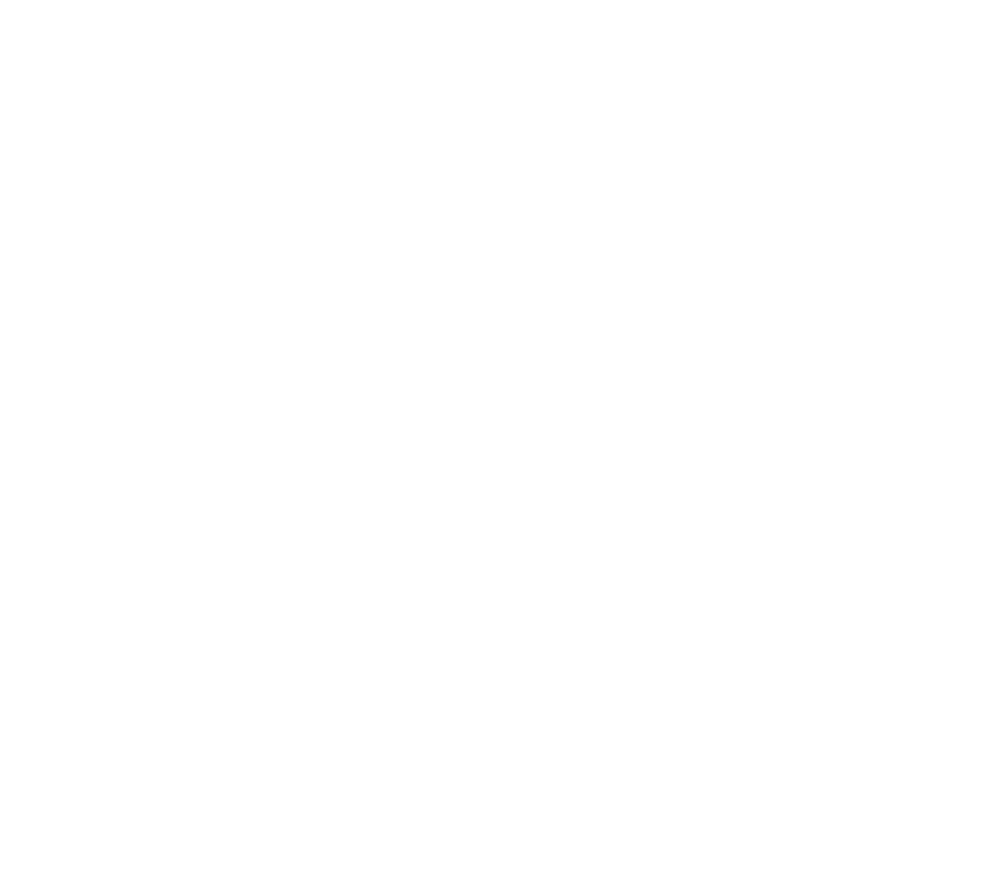

In [1]:
import cv2
import math
import numpy as np
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

SAFETY_FACTOR = 20 # margin so that the robot doesn't hit obstacles 
POLY_FACTOR_OBST = 0.05 # factor that determines how accurately the approxPolyDP function approximates
LEN_IN_MM = 113 # lenght of one side of the cube in mm

BLUE_LOW_H = 0
BLUE_HIGH_H = 20
BLUE_LOW_S = 50
BLUE_HIGH_S = 255
BLUE_LOW_V = 0
BLUE_HIGH_V = 255

def obstacles(img):
    """
    Extract obstacles from image "img", approximate them as polygons, find their corners and expand them
    
    param pic : image captured by the camera
    
    return new_corners : coordinates of the expanded obstacles corners
    return Pix_to_mm : pixel to millimeter conversion factor
    return img_goals : original image with black pixels except for the obstacles
    """
    low_blue = np.array([BLUE_LOW_H, BLUE_LOW_S, BLUE_LOW_V])
    high_blue = np.array([BLUE_HIGH_H, BLUE_HIGH_S, BLUE_HIGH_V])
    corners=[]
    new_corners=[]
    centroids=[]
    img_contours=img.copy()
    img_final = img.copy()
    
    img_obst, mask_obst = color_detect(img, low_blue, high_blue)
    contours, hierarchy = cv2.findContours(mask_obst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find largest area for noise condition
    areas = [cv2.contourArea(c) for c in contours]
    
    if not areas:
        cv2.imshow('mask', mask_obst)
        cv2.waitKey(0)
        raise ValueError("Can not read frame")
        
    max_cont = max(areas)
    
    # For each contour found, approximate it as a polygon and extract its corners
    for cont in contours:
        epsilon = POLY_FACTOR_OBST * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        
        if(len(approx)>2 and cv2.contourArea(approx) >= max_cont/3): # Condition to get rid of detected noise 
            cv2.drawContours(img_contours, [approx], -1, (0, 0, 255), 2)
            corners.append(approx)
            if(len(approx) == 4): # Use rectangle obstacle to find the pixel to millimeter conversion factor
                Pix_to_mm = pix_to_mm(approx)
    
    # From extracted corners, define middle point of each object and create vertex (by 'expanding' corners)
    
    for i in range(0, len(corners)):
        centroids.append(centroid(corners[i]))
        new_corners.append(expand(centroids[i], corners[i], Pix_to_mm))   # Determine expanded corners (to take into account thymio width)    
    
        for corn in new_corners[i]:
            cv2.circle(img_final, corn, 8, (0, 0, 255) , -1)

    return new_corners, Pix_to_mm, mask_obst, img_final, img_contours

def color_detect(pic, low, high):
    """
    Extract color from the image "pic" based on the HSV color range [low-high]
    
    param pic : image on which the color detection is conducted
    param low : contains the lower values of the HSV parameters range
    param high : contains the higher values of the HSV parameters range
    
    return color_img : original image with black pixels except for the color detected
    return mask : black and white color filter
    """
    
    sigma = (5,5)
    
    image=cv2.blur(pic, sigma)                 # Blurring to get rid of image noise
    image=cv2.cvtColor(pic, cv2.COLOR_RGB2HSV) 
    mask=cv2.inRange(image, low, high)
    mask=cv2.erode(mask, None, iterations=4)    # Processing to have smoother color filter
    mask=cv2.dilate(mask, None, iterations=4)   

    color_img =cv2.bitwise_and(pic, pic, mask=mask)
    
    return color_img, mask

def expand(centroid, vertexes, px_factor):
    """
    Computes the expanded vertexes of a polygon based on the coordinates of its corners and centroid
    
    param centroid : coordinates of centroid of obstacle 
    param vertexes : corners coordinates of obstacle
    param px_factor : pixel to millimeter conversion factor
    
    return new_corners : coordinates of expanded corners
    """
    
    
    half_thymio = SAFETY_FACTOR*(1/px_factor) # Thymio's half width - converted from mm to pixels
    if(len(vertexes) == 3): 
        expansion_dist = half_thymio/np.cos(np.pi/3) # For triangular obstacles
        
    else:
        expansion_dist = math.sqrt(2*half_thymio**2) # For rectangular obstacles
        
        
    new_corners = []
    
    for vertex in vertexes:
        dist = [(vertex[0][0] - centroid[0]), (vertex[0][1] - centroid[1])] # Distance between centroid and corner
        angle = np.arctan2(dist[1], dist[0])                                # Angle between centroid and corner
        new_coord = [vertex[0][0] + np.cos(angle)*expansion_dist, vertex[0][1] + np.sin(angle)*expansion_dist]
        new_corners.append(new_coord)
    
    new_corners = np.int0(new_corners)
    return new_corners

def centroid(vertexes):
    """
    Computes the coordinates of the centroid of a polygon given its corners coordinates
    
    param vertexes : corners coordinates of polygon
    
    return (x,y) : tuple of coordinates of the centroid of the polygon
    """
    
    x_list = [vertex [0][0] for vertex in vertexes]
    y_list = [vertex [0][1] for vertex in vertexes]
    length = len(vertexes)
    x = np.int0(sum(x_list) / length)
    y = np.int0(sum(y_list) / length)
    
    return(x, y)

def pix_to_mm(rectangle):
    """
    Extract longest side of rectangle and computes pixel to millimeter conversion factor from it
    
    param rectangle : coordinates of the corners of the rectangular obstacle
    
    return px_to_mm : pixel to millimeter conversion factor
    """
    len_in_px = 0
    
    for corn1 in rectangle:
        for corn2 in rectangle:
            if(np.any(corn1 != corn2)):
                dist = math.dist(corn1[0], corn2[0])
                if(dist > len_in_px):
                    len_in_px = dist

    px_to_mm = LEN_IN_MM/len_in_px
    
    return px_to_mm

img = cv2.imread('Images report/image_vision.jpg', cv2.IMREAD_COLOR)
vertexes, px_factor, mask, img_obst, img_contours = obstacles(img)
plt.figure(figsize=(8, 7))
plt.subplot(221),plt.imshow(img[:,:,::-1]),plt.title('Input')
plt.subplot(222),plt.imshow(mask),plt.title('Color filter')
plt.subplot(223),plt.imshow(img_contours[:,:,::-1]),plt.title('Polygon Approximation')
plt.subplot(224),plt.imshow(img_obst[:,:,::-1]),plt.title('Vertexes for path planning')
plt.show()

As can be seen from this figure, the obstacle() function does not only extract the obstacles from the image but it also finds their corners and expand them in order to take into account the real size of the robot. This is done following those steps: 
- finding the contours of the "Color filter" image
- approximating those contours as polygons (see image "Polygon approximation") and extracting their corners
- expanding the corners using the centroids() and expand() functions (see image "Vertexes for path planning" in which red dots represent the vertexes)

Once the contours are found, the area of the largest contour is computed and used to create a condition that ignores small contours which can be considered as noise detected by the color filter. The condition used is the following: <br><br>if $area_{current} < \frac{area_{largest}}{3}$ then the current contour is ignored.

Another important feature of the obstacle() function is to calculate the pixel to millimeter conversion factor by dividing the measured length (113mm) of the longest side of the rectangle obstacle by its length in pixels. <br><br>

The distance by which the corners are expanded depends on the shape of the obstacle as we want to make sure that the robot doesn't hit the obstacle when going from one of its corners to another. By doing simple trigonometry, we obtain that the expansion distance should be (as can bee seen on the figure below):
- Triangle : $dist_{expansion}$ = $\frac{width_{thymio}}{2*cos(60)}$
- Rectangle : $dist_{expansion}$ = $\sqrt{2 * (\frac{width_{thymio}}{2})^2}$

<img src='images report\Expansion vision.jpg' alt="Modules" style="width: 600px;"/>

### Goals 

The center of the goals are defined in a very similar way. Once the contours are extracted from the color filter, the smallest enclosing circle is fitted to each goal and its center is returned. In the plot below, the centers of the goals are drawn as red dots.

<IPython.core.display.Javascript object>


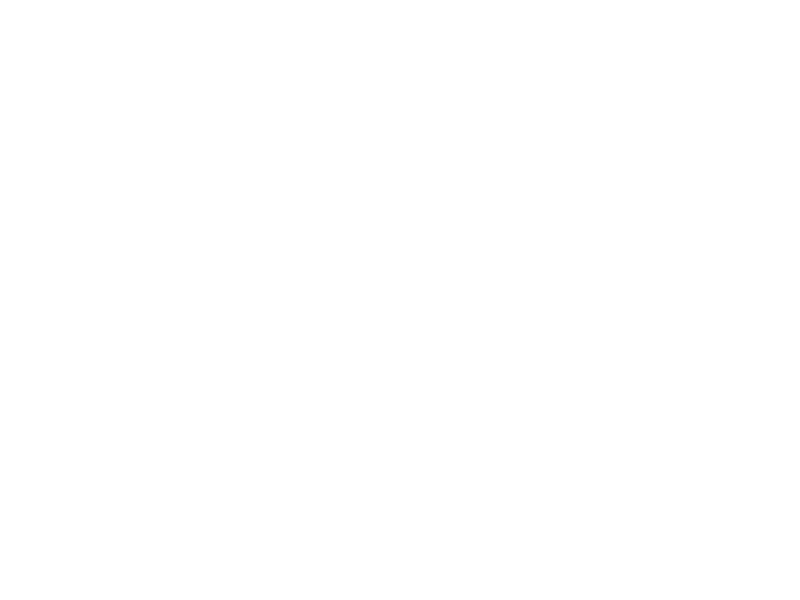

In [2]:
GREEN_LOW_H = 50
GREEN_HIGH_H = 70
GREEN_LOW_S = 50
GREEN_HIGH_S = 255
GREEN_LOW_V = 50
GREEN_HIGH_V = 255

def goals(pic):
    """
    Extract goals from image "pic" and find their centers
    
    param pic : image captured by the camera
    
    return goals_loc : coordinates of the centers of the goals
    return img_goals : original image with black pixels except for the goals
    """
    
    low_green = np.array([GREEN_LOW_H, GREEN_LOW_S, GREEN_LOW_V])
    high_green = np.array([GREEN_HIGH_H, GREEN_HIGH_S, GREEN_HIGH_V])

    goals_loc = []
    img_goals = pic.copy()
    
    # Extract goals from original image through color detection
    colored_mask, mask_goals = color_detect(pic, low_green, high_green)

    contours=cv2.findContours(mask_goals, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    # For each contour found, fit the minimum enclosing circle and extract center
    for cont in contours: 
        
        ((x, y), rayon)=cv2.minEnclosingCircle(cont)
        goals_loc.append(np.array([int(x),int(y)]))
        
    #draw centers of goals
    for cent in goals_loc:
        cv2.circle(img_goals, cent, 5, (0, 0, 255) , -1)
    
    return goals_loc, img_goals

goals_centers, img_goals = goals(img)
plt.figure()
plt.imshow(img_goals[:,:,::-1])

### Thymio 

The red rectangle placed on top of the Thymio is at the center of the wheels axis and is detected in the same way as the obstacles to determine the position of the robot. Thus, we won't describe this implementation. However, to have the full pose of the Thymio, we also need its orientation. This is made possible by the red triangle which allows to detect the position of a second point on the Thymio, from which the orientation can be calculated. Once the centers of the rectangle and triangle are computed, the angle is calculated using those two lines of code:

The arctan2() function returns an angle in the range $[-\pi, \pi]$ which is then converted to the $[0, 2\pi]$ range by doing modulo 2$\pi$. The angle obtained represents the clockwise orientation of the robot with respect to the horizontal axis of the camera and with origin at the center of the red rectangle (see representation below).
<img src='images report\Angle robot.jpg' alt="Modules" style="width: 400px;"/>

# Global Navigation

Once the position of the robot, of the goals and of the obstacles are known, we need to find the shortest path that visits all the goals and comes back to the starting position while avoiding obstacles.

The path planning is divided in two subfunctions:
1. Visibility graph algorithm: find the shortest path between all pairs of goal/goal and goal/start positions and store their lengths.
2. Travelling salesman problem: run a genetic algorithm using the previously computed lengths as the distances separating the points.

## Visibility graph

In this function, we used the library pyvisgraph (https://github.com/TaipanRex/pyvisgraph).

The first step is to generate the visibility graph. We need to know the "neighbors" of each point and the distance between each point and its neighbors. 

To know if point a and b are neighbors, we need to check if the segment [a,b] intersects with any of the sides of the obstacles. 
If it is not the case, we can connect a and b in the visibility graph and store the distance that separates them.

This is done with the function `g.build(polys)` at line 69 in the code below.

<img src='images report\vis1.png' alt="Modules" style="width: 400px;"/>

*Example of a visibility graph (source: https://fribbels.github.io/shortestpath/writeup.html)*


We then apply the Djikstra algorithm to find the shortest path between all pairs of goal/goal and goal/start positions.

The complexity of the Djikstra algorithm is $O(k^2)$ and we need to solve the Djikstra algorithm $n!$ times. With n = number of goal + 1 (+1 to add the start position) and k the number of nodes in the visibility graph.
This is not optimal if n gets big. The total complexity is $O(n!*k^2)$. 
What we could have done to reduce that complexity is to modify the Djikstra algorithm such that it finds the shortest path from one point to all other points in one execution. We would then need to solve that modified Djikstra only n times and the total complexity would have been $O(n*k^2)$.

In our use case, $k=15$ and $n=4$. Therefore $O(n*k^2) = 900$ and $O(n!*k^2) = 5400$. 

The difference is not huge, and the later option only needs around 0.015 seconds to run on my computer. Therefore, we decided to reuse the function that comes from the pyvisgraph library and call it $n!$ times. 

100%|██████████| 2/2 [00:00<00:00, 334.26it/s]

Elapsed time is: 0.02196955680847168


<IPython.core.display.Javascript object>


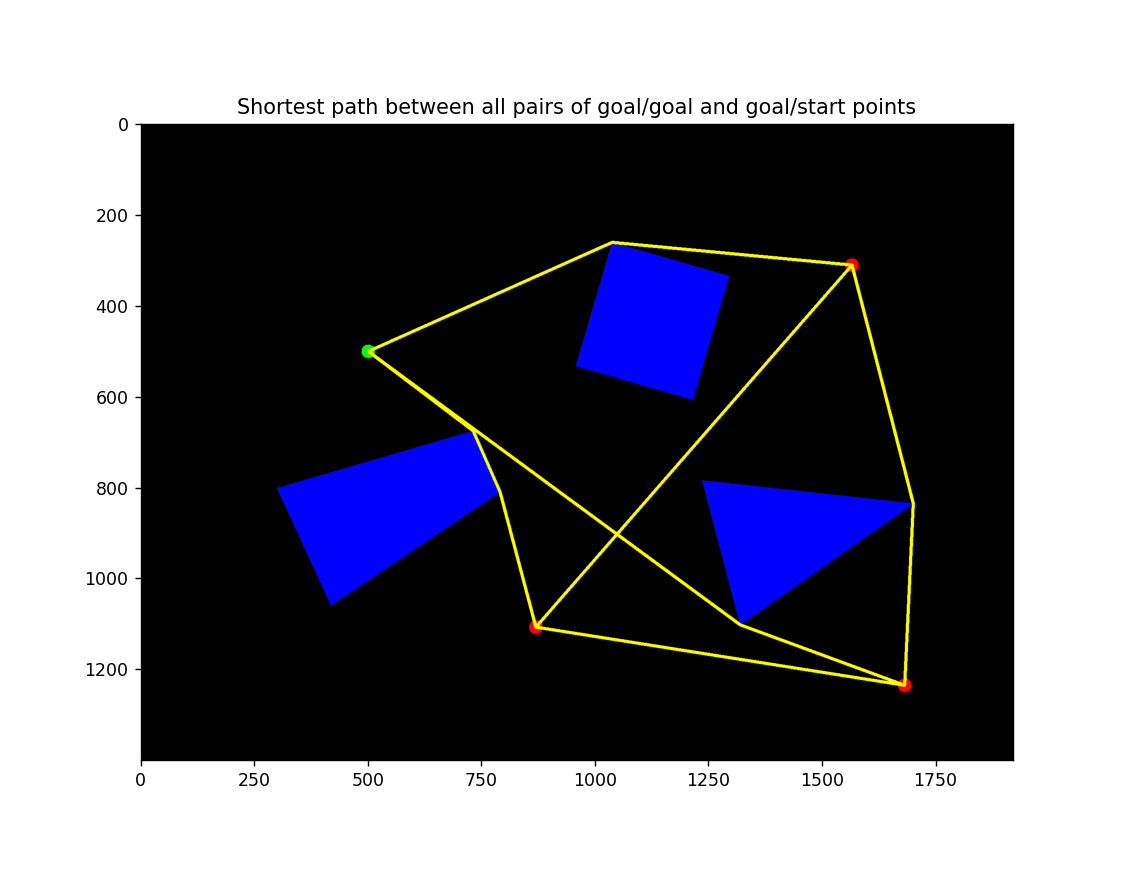

Legend: 
Green point: start point
Red points: goal points
Blue polygons: obstacles
Yellow lines: shortest paths


In [9]:
import pyvisgraph as vg
import numpy as np
import cv2
import math
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook
import time

def draw(image, start, goal, obstacle):
        
        cv2.circle(image, start,radius=0, color=(0,255,0), thickness=30)

        for current_goal in goal:
            cv2.circle(image, current_goal,radius=0, color=(255,0,0), thickness=30) 

        #draw obstacle
        cv2.fillPoly(image, obstacle, color=(0,0,255))

def path_length(path):
    """
    Computes the length of a path
    
    param path: positions of all the points composing the path
    
    return distance: length of the path
    """
    distance = 0
    for i in range(len(path)-1):
        distance += math.sqrt((path[i].x-path[i+1].x)**2 + (path[i].y-path[i+1].y)**2)
    
    return distance

def visibility_graph(start, goal, obstacle,draw = False, image = None):
    """
    Use visibility graph and Djikstra algorithm to find the shortest distance 
    and its corresponding path between each pair of goals.
    This library is used: https://github.com/TaipanRex/pyvisgraph
    
    param start: position of the robot at the beginning
    param goal: list of position of goals where the robot has to go
    param obstacle: list of position of the corners of the extended obstacles
    param draw: if True, all the shortest path between pair of goals/start will be ploted
    param image: the image on which we draw the path
    
    return dist_list: list of the lengths of all shortest paths
    return path_list: list of intermediate coordinates composing each of shortest path
    """
    
    polys = [] 
    #creates the list of obstacle with the format needed by pyvisgraph library
    for cobstacle in obstacle: 
        cpolys = []
        for cpos in cobstacle:
            cpolys.append(vg.Point(cpos[0],cpos[1])) 
        polys.append(cpolys)
    
    #point is the list of goals in wich we insert the start position
    point = goal.copy()
    point.insert(0, start)
    dist_list=[]
    path_list=[]

    #create the visibility graph
    g = vg.VisGraph()
    g.build(polys)
        
    #for each pair of point (in point list), we compute the shortest path
    for i in range(len(point)):
        for k in range(len(point)-i-1):
            j = k+i+1
            #computes the shortest path between point i and j
            shortest = g.shortest_path(vg.Point(point[i][0], point[i][1]), vg.Point(point[j][0], point[j][1]))
            #add the shortest path into the path_list
            path_list.append([i, j, shortest])
            #add the length of the sortest path in the dist_list
            dist_list.append((i, j, path_length(shortest)))
            
            #if param draw = True, draw all the sortest paths on param image
            if draw:
                h = 0
                for h in range (len(shortest)-1):
                    dstart = np.array([int(shortest[h].x), int(shortest[h].y)])
                    dend = np.array([int(shortest[h+1].x), int(shortest[h+1].y)])
                    image = cv2.line(image,dstart, dend, color=(255,255,0), thickness = 5)
                
    return dist_list, path_list

#Exemple data
start = np.array([500,500])

goal = []
goal.append(np.array([1681,1235]))
goal.append(np.array([ 869, 1107]))
goal.append(np.array([1565, 310]))

obstacle = []
obstacle.append(np.array( [[1235,  784],[1319, 1102],[1700,  835]]))
obstacle.append(np.array( [[ 731,  675],[ 299,  801],[ 418, 1059],[ 790,  809]])) 
obstacle.append(np.array( [[1037,  260],[ 957,  532],[1214,  606],[1294,  334]])) 

#empty black image
image = np.zeros((1400,1920,3), np.uint8)

#draw the elements in the map
draw(image, start, goal, obstacle)

previous_time = time.time()

#compute the shortest distance between all pairs of goal/goal and goal/start positions
dist_list, path_list = visibility_graph(start, goal, obstacle, True, image)

print("Elapsed time is:", time.time()-previous_time)

plt.figure(figsize=(9, 7))
plt.imshow(image)
plt.title('Shortest path between all pairs of goal/goal and goal/start points')
# plt.legend('test')
plt.show()

print('Legend: \nGreen point: start point\nRed points: goal points\nBlue polygons: obstacles\nYellow lines: shortest paths')

## Travelling salesman problem

We now know the "distance" that separates each point that we need to visit. 

Note that the distance that separates each pair of points is not the euclidian distance! It is the length of the shortest path that separates those 2 points (taking into account the obstacles). 

We need to find the shortest path that visits all of the points and then go back to the start position.

This problem is called the travelling salesman problem and is very well documented. 

To solve it, we used the library mlrose (https://github.com/gkhayes/mlrose), that uses a genetic algorithm.

Note that given our low number of points, we could have used the brute force method and still solve the problem in a reasonable amount of time. But we thought that using a genetic algorithm is more elegant.

<IPython.core.display.Javascript object>


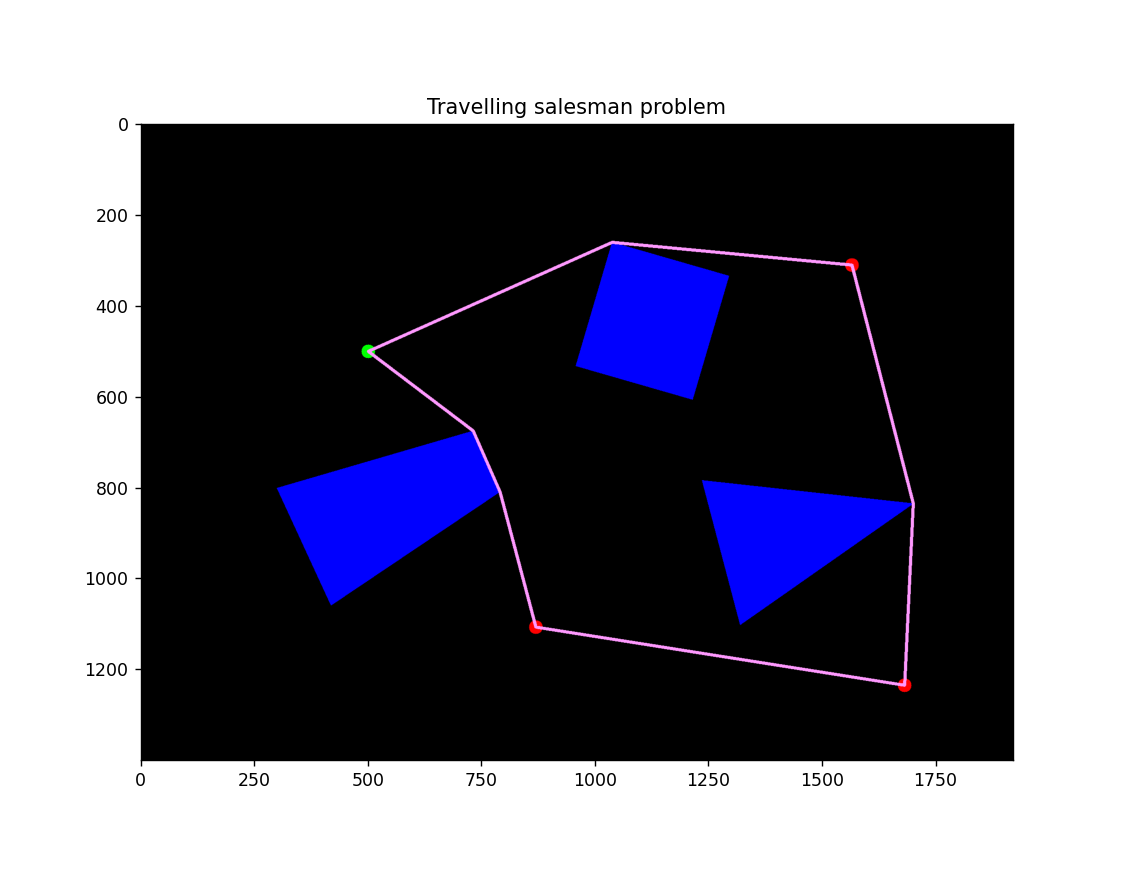

Legend: 
Green point: start point
Red points: goal points
Blue polygons: obstacles
Pink line: shortest path to visit all the goals and go back to starting point while avoiding obstacles


In [4]:
def tsp(dist_list, path_list, length, draw = False, image = None):
    """
    Solve the travelling salesman problem using a genetic algorithm.
    The library used is mlrose: https://github.com/gkhayes/mlrose
    
    param dist_list: list of the lengths of all shortest paths
    param path_list: list of intermediate coordinates composing each of shortest path
    param length: number of points to travel to
    param draw: if True, all the shortest path between pair of goals/start will be ploted
    param image: the image on which we draw the path
    
    return optimal_trajectory: list of points that compose the optimal path (expressed in pixel coordinates)
    """
    
    optimal_trajectory=[]

    # Initialize fitness function object using dist_list (dist_list is the length of the 
    # pairwise shortest path computed in Astar function)
    fitness_dists = mlrose.TravellingSales(distances = dist_list)
    # Define optimization problem object
    problem_fit2 = mlrose.TSPOpt(length, fitness_fn = fitness_dists, maximize = False)
    # Solve using genetic algorithm
    best_state, best_fitness = mlrose.genetic_alg(problem_fit2, mutation_prob = 0.2, max_attempts = 100,
                                                  random_state = 2)
    
    #rearrange best state so that the path starts at the start position
    while best_state[0] != 0:
        best_state = np.roll(best_state,1)
        
        
    #fill the optimal tarjectory list using best_state and path_list
    for i in range(len(best_state)):
        start = best_state[i]
        if i == len(best_state)-1:
            stop = best_state[0]
        else:
            stop = best_state[i+1]
            
        for segment in path_list:
            if (segment[0] == start and segment[1] == stop):
                segment_path = segment[2]
                for j in range(len(segment_path)-1):
                    optimal_trajectory.append(np.array([segment_path[j].x, segment_path[j].y]))
            if (segment[1] == start and segment[0] == stop):
                segment_path = segment[2]
                for k in range(len(segment_path)-1):
                    j = len(segment_path) - 1 - k
                    optimal_trajectory.append(np.array([segment_path[j].x, segment_path[j].y]))
        
    optimal_trajectory.append(np.array([path_list[0][2][0].x,path_list[0][2][0].y]))  
    
    #if param draw = True, draw the sortest path on param image
    if draw:
        for i in range(len(optimal_trajectory)):
            start = optimal_trajectory[i].astype(int)
            if i == len(optimal_trajectory)-1:
                stop = optimal_trajectory[0].astype(int)
            else:
                stop = optimal_trajectory[i+1].astype(int)
                
            image = cv2.line(image,start, stop, color=(255, 153, 255), thickness = 5)
    
   
    return optimal_trajectory

#empty black image
image = np.zeros((1400,1920,3), np.uint8)

#draw the elements in the map
draw(image, start, goal, obstacle)

#compute the Travelling salesman problem algorithm and plot the paths
optimal_path = tsp(dist_list, path_list, len(goal)+1, draw, image)


plt.figure(figsize=(9, 7))
plt.imshow(image)
plt.title('Travelling salesman problem')
plt.show()
print('Legend: \nGreen point: start point\nRed points: goal points\nBlue polygons: obstacles\nPink line: shortest path to visit all the goals and go back to starting point while avoiding obstacles')

# Local Navigation

When following the global path previously calculated, the Thymio is sensing its environment. In case an unpredicted obstacle appears on its way, it detects it and avoids it.
Based on the Artificial Neural Network technique, we added weights as fixed connections between the horizontal proximity sensors and the two motors. This way, we have a reactive control tuned empirically.

We made the choice to use an ANN with memory to have a recurrent connection, that allows in most simple cases to avoid bumping into an obstacle and go far enough to be able to get back in the planned path tracks!                                                         
To access the synchronized variables from the Thymio, we added two functions in our main, with the `@tdmclient.notebook.sync_var` (`set_speed()` and `get_prox()`). This allows us to have updated values from the sensors and compute the wheels' speed accordingly.


Basically, the function is a local avoidance with memory, you can find its code below.

In [5]:
SENS_SCALE = 1300
CST_SCALE = 2
SPEED_TRH = 140
AVG_SPEED = 70

def obstacle_avoidance(horz_prox, speedl, speedr, verbose = False):
    
    '''
    Computes the speed of the robot depending of the distance to the obstacle,
    based on an Artificial Neural Network with memory.
    
    INPUT
        :param horz_prox 
            1x7 NumPy Array collecting the values from the horizontal 
            proximity sensors
        :param speedl, speedr 
            respective current speeds of left and right motors
             
    OUTPUT
        :return y 
            1x2 NumPy Array [speedl, speedr] of speeds of the wheels [mm/s]
        :return state
            state of the robot 
            1 --> obstacle avoidance
            0 --> goal tracking
    '''
    
    w_l = [20,  20, -20, -20, -20,  0, 0, 1, 0]
    w_r = [-22, -22, -22,  22, 22, 0, 0, 0, 1]

    x = [0,0,0,0,0,0,0,0,0]
    
    y = [speedl,speedr]
   
    # Memory
    x[7] = y[0]/CST_SCALE
    x[8] = y[1]/CST_SCALE
    
    if verbose: print("remanent left speed: ", x[7])
    if verbose: print("remanent right speed: ", x[8])

    for i in range(7):
        # Get and scale inputs
        x[i] = horz_prox[i] / SENS_SCALE

    y = [0,0]   

    for i in range(len(x)):    
        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]
        
    y[0] = int(y[0]+AVG_SPEED)
    y[1] = int(y[1]+AVG_SPEED)
    
    if verbose: print("left speed: ", x[7])
    if verbose: print("right speed: ", x[8])
        
    state = 1
    
    if y[0]<=SPEED_TRH and y[1]<=SPEED_TRH:
        # Back to goal tracking
        state = 0
        
    return y, state

It manages the `state` of the robot, avoiding us to have a parallel loop to handle obstacle avoidance and keep our main running. 
When an obstacle is detected, the state goes to `1` as the speed of the robot is faster than the threshold (condition line `56`). This is our way to manage the effect of memory. With the tuning of the weights, they both prevent the robot to turn too much. Once the threshold exceeded, the state goes back to `0` and the Thymio follows back its planned path.

We decided not to take into account the back sensors as the robot won't go backwards and it makes it easier to manipulate it, for a kidnapping as an example.

If the add of the memory allows a smoother avoidance of the unpredicted obstacle, the add of the `AVG_SPEED` to the speed of the motors allows a better avoidance. Indeed, once the sensors don't detect the obstacle anymore, the robot wants to turn back in the tracks of its optimal path, but it hasn't not necessarily overcome the obstacle. 

Here is a simple schematic to visualise what is happening when an unpredictable obstacle appears in the range of sensing of the Thymio.

<img src='images report\AVOID.png' alt="Modules" style="width: 400px;"/>

# Kalman filter

The robot's position can be obtained either by measuring it with the camera, or by predicting the robot's position relying on the odometry. The goal of the Kalman filter is to compute a better estimation of the position by taking both of these methods into account. Each of these ways of obtaining the position has its own uncertainties (level of error). The estimation will rely more on the method with the smallest error variance. In our case, it will rely more on the camera measurements, since they are more accurate.

However, the prediction of the odometry will be useful when the camera is not able to detect the position of the robot (ex: when the camera is hidden or the camera doesn't succeed at detecting the robot). In this case, the estimation of the position will use the prediction of the odometry to ensure a good positioning of the robot until the camera is back.

We chose to use a Kalman filter and not another type of filter because the noises of the sensors can be approximated as Gaussian.

### Modeling the filter

In our case we want to predict the position of the robot  $x = [x,y,\alpha]$. Let's start by defining the discrete-time state-space model $x_{k+1} = f(x_k, u_k)$ (where $x_k$ is a vector of the position of the robot in the global reference frame, i.e. $x_k =$ $[x_{k}; y_{k}; \alpha_{k}]$ ).

The fixed sampling time is $T_s$ and the control input is $u_k = [v_{k}; \omega_{k}]$, where the speed is the average of the two wheels  $v = \frac{(v_{left} + v_{right})\times factor}{2}$ and $\omega$ is the rotation speed of the robot $\omega = (v_{left} - v_{right})\times factor$. Both of the conversions factors have been estimated first by testing the odometry of the robot, like in the exercice sessions, and then by adjusting these factors by hand. They ensure a good conversion of the speeds to real world scales, in $mm/s$ and $deg/s$.

 <span style="color: #2980B9 ;">

<blockquote>
Let the state $x$ contain the positions in $mm$ and the angle in $degrees$. The discrete-time state-space model is :

$x_{k+1}= A_k x_k + B_k u_k + w_k = \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}x_k+ \begin{bmatrix} cos(\alpha)\times Ts & 0 \\ sin(\alpha)\times Ts & 0 \\ 0 & Ts\end{bmatrix}u_k+w_k$
   
where $w_k$ is the process noise with mean zero and covariance $Q$.

This translates in the new state $x_{k+1} = [x_{k+1}; y_{k+1}; \alpha_{k+1}]$ 


The theory behind a classical Kalman filter requires the state model to be linear. In the case of a differential robot this is clearly not the case, as the matrix $B_k$ depends on $\alpha$. For non-linear systems, one should use an extended Kalman filter. Since we had really good results by applying a classical Kalman filter, it seemed like this approximation was good enough, and we did not need to use an extended Kalman filter.

<span style="color: #2980B9 ;">

<blockquote>
   
When estimating the position of the robot there are two distinct scenarios: 

1. When the camera can detect the position of the robot:
    
    We apply a classic Kalman filter:

      $y_k^T = H^Tx_k + \nu_k^T =  \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1\end{bmatrix}x_k+\nu_k^T$

      where $\nu_k^T$  is the measurement noise with zero mean and covariance $R^T$. For simplicity we will assume that the measurement noise on each position is independent. Hence $R^T$ is a diagonal matrix $R^T = \begin{bmatrix} r_x & 0 & 0\\ 0 & r_y & 0\\ 0 & 0 & r_\alpha\end{bmatrix}$


2. When the camera can't detect the position of the robot:
    
   We can only use the speed of the robot and the state model to predict the next position.
    
    


### Tuning of the noise matrices

Since the camera we used for this project has a really high accuracy we want the Kalman filter to rely more on the camera measurements than on the odometry when estimating the position. The values of the matrix $Q$ have been set to bigger values than $R$ .

### Experiment
The image below shows explicitly what happens when the robot thinks the camera is hidden. We fooled the robot into thinking that the camera was hidden and plotted its trajectory with a pink line. In this case, the robot was only relying on the state model and the odometry to move. The red line represents the trajectory the robot thinks it is following. From this experiment we can clearly see that even if the state model is correct, the errors linked to the odometry are non-neglectable. By the end of its trajectory, the total error linked to the odometry is so high that the robot is not aligned with the last goal at all and has run into an obstacle. This clearly proves that taking into account the position detected by the camera is necessary, in order to compensate these errors. On the other hand, we can see that the odometry can be realiable, especially during shorts periods of time when the camera doesn't detect the position of the robot.

<img src='images report\Kalman_filter.png' alt="Modules" style="width: 600px;"/>

*LEGEND:*
 
 *Red: Path the robot thinks he is following*
 
  *Pink: Real displacement of the robot based on the odometry only*

In [6]:
KP = 3
DEG_LIM = 10
SPEED_AVG = 150
DT = 0.1
SPEED_TO_MMS = 0.37796 #Conversion factor to convert speed to mm/s
YAW_TO_DEGS = 0.24344 #Conversion factor to convert angular speed to deg/s

def kf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk, hidden_cam, verbose = False):
    """
    Modified from Addison Sears-Collins: https://automaticaddison.com
    
    Kalman Filter. Fuses noisy sensor measurement to 
    create an optimal estimate of the state of the robotic system.
         
    INPUT
        :param z_k_observation_vector The observation from the odometry
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [mm,mm,degrees].
        :param state_estimate_k_minus_1 The state estimate at time k-1
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [mm,mm,degrees].
        :param control_vector_k_minus_1 The control vector applied at time k-1
            3x1 NumPy Array [v,v,yaw rate] in the global reference frame
            in [mm/s,mm/s,degrees/s)].
        :param P_k_minus_1 The state covariance matrix estimate at time k-1
            3x3 NumPy Array
        :param dk Time interval in seconds
        :param hidden_cam boolean which is True if the camera is hidden
             
    OUTPUT
        :return state_estimate_k near-optimal state estimate at time k  
            3x1 NumPy Array ---> [mm,mm,degrees]
        :return P_k state covariance_estimate for time k
            3x3 NumPy Array                 
    """
    # A matrix
    A_k_minus_1 = np.array([[1.0,  0,   0],
                           [  0, 1.0,   0],
                           [  0,   0, 1.0]])

    # State model noise covariance matrix Q_k
    Q_k = np.array([[1.0,   0,   0],
                    [  0, 1.0,   0],
                    [  0,   0, 1.0]])
                     
    # Measurement matrix H_k
    H_k = np.array([[1.0,  0,   0],
                    [  0,1.0,   0],
                    [  0,  0, 1.0]])
                             
    # Sensor measurement noise covariance matrix R_k
    R_k = np.array([[0.1,   0,    0],
                    [  0, 0.1,    0],
                    [  0,    0, 0.1]])  
    
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state 
    # estimate at time k-1 and the control input applied at time k-1.
    if verbose: print(f'Camera measurement={z_k_observation_vector}')

    state_estimate_k = A_k_minus_1 @ (
            state_estimate_k_minus_1) + (
            getB(state_estimate_k_minus_1[2],dk)) @ (
            control_vector_k_minus_1)
                    
    if verbose: print(f'X_est State Estimate Before KF={state_estimate_k}')
    
    if not hidden_cam:
        # Predict the state covariance estimate based on the previous
        # covariance and some noise
        P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
                Q_k)
             
        ################### Update (Correct) ##########################
        # Calculate the difference between the actual sensor measurements
        # at time k minus what the measurement model predicted 
        # the sensor measurements would be for the current timestep k.
        measurement_residual_y_k = z_k_observation_vector - (
                H_k @ state_estimate_k)
                 
        # Calculate the measurement residual covariance
        S_k = H_k @ P_k @ H_k.T + R_k
             
        # Calculate the Kalman gain
        K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)
             
        # Calculate an updated state estimate for time k
        state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)
         
        # Update the state covariance estimate for time k
        P_k = P_k - (K_k @ H_k @ P_k)
         
        # Print the best estimate of the current state of the robot
        if verbose: print(f'X_est State Estimate After KF={state_estimate_k}')
    else:
        if verbose: print('THE CAMERA IS HIDDEN')
        P_k = P_k_minus_1
        
        
    if verbose: print(f'covariance_estimate_t={P_k}')
    if verbose: print()
    
    # Return the updated state and covariance estimates
    return state_estimate_k, P_k

def getB(yaw, deltak):
    """
    Calculates the B matrix which expresses how the state of the system changes
    from k-1 to k due to the control commands (i.e. control input). 
    The control inputs are the forward speed and the
    rotation rate around the z axis.[v,yaw_rate]
    
    INPUT
        :param yaw The angle of the robot in the global reference frame
        in [degrees].
        :param deltak Time interval in seconds
            
    OUTPUT
        :returns B Matrix (nb_of_state_inputs x nb_control_inputs): (3x2)
    """
    B = np.array([  [np.cos(np.deg2rad(yaw))*deltak, 0],
                    [np.sin(np.deg2rad(yaw))*deltak, 0],
                    [0, deltak]])
    return B


# State covariance matrix P_t_minus_1
P_t_minus_1 = np.array([[1,  0,   0],
                        [0,  1,   0],
                        [0,  0,   1]])


x_est_t_minus_1 = np.array([1,0,0])
obs_vector_z_t = np.array([140, 50, 30])

hidden_cam = 0
v_l = 100
v_r = 100

v = (v_l + v_r)*SPEED_TO_MMS/2
yaw = (v_l-v_r)*YAW_TO_DEGS

# The control input vector at time t-1 in the global reference frame.
# [v, yaw_rate]
# [mm/s, degrees/s] 
u_t_minus_1 = [v, yaw]; 


print(f'x_est_t_minus_1 ={x_est_t_minus_1 }')

optimal_state_estimate_t, covariance_estimate_t = kf(
    obs_vector_z_t, # Most recent sensor measurement
    x_est_t_minus_1, # Our most recent estimate of the state
    u_t_minus_1, # Our most recent control input
    P_t_minus_1, # Our most recent state covariance matrix
    DT,hidden_cam, True) # Indicator of the camera state


x_est_t_minus_1 =[1 0 0]
Camera measurement=[140  50  30]
X_est State Estimate Before KF=[4.7796 0.     0.    ]
X_est State Estimate After KF=[133.56093333  47.61904762  28.57142857]
covariance_estimate_t=[[0.0952381 0.        0.       ]
 [0.        0.0952381 0.       ]
 [0.        0.        0.0952381]]



# Motion Control: P controller


We started with the idea of implementing a PID controller, in order to compute the speeds of the wheels depending on the angular position of the robot. The goal is to minimize the error angle, which is the angle between the robot and its goal. After multiple testings, we realised that a proportional controller was enough to ensure a good displacement.

The image below shows the displacement of the robot (in blue) compared to the "perfect path" returned by the path planning algorithm (in red). As we can see, the angular residual error of the robot is really small. Thus, we decided to remove the integral term. Since we didn't have any oscillating behaviour, we removed the derivative term too.

<img src='images report\pid.png' alt="Modules" style="width: 600px;"/>

*LEGEND:*

 *Blue: displacement of the robot*
 
 *Red: optimal path*

<span style="color: #2980B9 ;">
    
<blockquote>
   
Our controler computes the speed of the wheels following two distinct scenarios:
    
1. The angle between the robot and the goal is large: The robot turns until the error angle is small enough.
2. The angle between the robot and the goal is small: The robot moves forward while turning, aligning with the direction of the goal.

The error angle is considered as small if it is under 10 degrees (threshold). The error angle is computed by substracting the angle between the center of the robot and the goal to the angular position of the robot. Both angles had to be mapped between $[-180^{\circ},180^{\circ}]$.

In [7]:

def p_controler(pos_robot, pos_goal, verbose = False):
    '''
    Computes the speed of the robot proportionaly to the error orientation
    /remaining distance to the goal.
    
    INPUT
        :param pos_robot 
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [mm,mm,degrees].
        :param pos_goal 
            3x1 NumPy Array [x,y] in the global reference frame
            in [mm,mm].
             
    OUTPUT
        :return v_l Left wheel speed: mm/s
        :return v_r Right wheel speed: mm/s
    '''   
    angle_rad = np.arctan2(pos_goal[1]-pos_robot[1],pos_goal[0]-pos_robot[0])
    
    angle_robot = twopi_to_pi(pos_robot[2])

    if verbose: print("Robot_angle:",angle_robot)
    
    angle_goal = math.degrees(angle_rad)
        
    # Computes the error angle from the angle of the robot in the global 
    # reference frame and the angle between the center of robot and the goal.
    error = twopi_to_pi(angle_robot-angle_goal)
    
    if verbose: print("Angle between the center of the robot and the goal: ", angle_goal)
    if verbose: print("Error_angle:",error)
    
    # Computes a speed proportional to the error
    speed = KP * error
    
    # Only moves forward while turning if the error angle is really small
    if abs(error) > DEG_LIM:
        v_l = - speed
        v_r = speed
        if verbose: print("Turning only, left and right wheel speed:",v_l,v_r)
    else:
        v_l = SPEED_AVG - speed
        v_r = SPEED_AVG + speed
        if verbose: print("Moving and turning, left and right wheel speed:",v_l,v_r)
    
    return v_l, v_r


def twopi_to_pi(angle):
    '''
    Converts [0,2pi] angles to [-pi,pi]
    
    INPUT
        :param angle in degrees [0,2pi]

    OUTPUT
        :return angle in degrees[-pi,pi]

    '''
    if angle < -180:
        angle = 360 + angle
    if angle >  180:
        angle = angle - 360
    
    return angle

pos_robot = np.array([0,0,0])
pos_goal = np.array([140,30])

v_l, v_r= p_controler(pos_robot, pos_goal, verbose = True)

Robot_angle: 0
Angle between the center of the robot and the goal:  12.094757077012101
Error_angle: -12.094757077012101
Turning only, left and right wheel speed: 36.2842712310363 -36.2842712310363


# Conclusion

As a conclusion, we feel like the results of this projects are good. Nevertheless, we faced a few difficulties.

First of all, the `vision` part was pretty tricky. We struggled to find a way to expand correctly the corners in order to avoid the obstacles. Also, the calibration of the color filters took us some time to be perfectly accurate.

Secondly, the `odometry` gave us a bit of a headache as it wasn't accurate enough on its own : in any case the use of a camera and a good Kalman filter were needed in order to have a good pose estimation.

Having a smooth `local avoidance` without proximity sensors on the sides of the robot was another struggle of ours. We could have used a more complex algorithm, using more states, to get back on tracks in an even smoother movement, avoiding the Thymio to turn towards the obstacle multiple times.

Adding a `display` all along the progress of the project was not easy, and quite time consuming at the beggining, but finally happened to be really helpful for understanding and debugging our code.

When splitting the work between the group members, we had to beware of interfaces between the different parts of the code.

In order to work in an efficient way as a group, we decided to set up a `Git` (https://github.com/henrypapadatos/Mobile_robotics).